# Import Libraries

In [20]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, learning_curve, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, roc_auc_score, confusion_matrix
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.dummy import DummyClassifier

from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier 
from sklearn import tree

from sqlalchemy import create_engine

%matplotlib inline

---

# Connect Database

In [ ]:
cnx = create_engine('postgresql://ubuntu:@18.225.36.12:5432/wine')
pd.read_sql_query('''SELECT * FROM winetable LIMIT 5;''', cnx)

---

# Define Functions

In [3]:
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.
    
    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.
        
    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
    """
    df_cm = pd.DataFrame(confusion_matrix, index=class_names, columns=class_names) 
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label');
    return plt.figure(figsize=figsize);

In [4]:
def roc_auc(model, name, y_val, X_val):
    '''Plots ROC Curve and AUC Score
    Inputs: Model to plot for, Name of Model, x and y test values
    '''
    fpr, tpr, thresholds = roc_curve(y_val, model.predict_proba(X_val)[:,1], pos_label=1)
    plt.plot(fpr, tpr,lw=2)
    plt.plot([0,1],[0,1],c='violet',ls='--')
    plt.xlim([-0.05,1.05])
    plt.ylim([-0.05,1.05])


    plt.xlabel('Falhttp://localhost:8888/notebooks/project3_LH.ipynb#se positive rate')
    plt.ylabel('True positive rate')
    plt.title(f'ROC curve for {name}');
    print("ROC AUC score = ", roc_auc_score(y_val, model.predict_proba(X_val)[:,1]))

In [5]:
def incorrect_rows(y_val, y_predictions):
    '''Returns a list of indexes where the predictions are incorrect
    Args: 
    y_val - Actual y values
    y_predictions - y predictions from model
    
    Output Type: List
    '''
    
    # Idx:Actuals
    y_values = dict(y_val)
    y_predicted = list(y_predictions)

    # Split dict into list of idx and actuals
    indexes = []
    actuals = []
    for key, value in y_values.items():
        indexes.append(key)
        actuals.append(value)

    # Create a list of tuples (actual values, predictions)
    acts_preds = list(zip(actuals, y_predicted))

    # Iterate through and determine whether prediction was correct or not
    predictions = []
    for idx,(act,pred) in enumerate(acts_preds):
        if act == pred:
            predictions.append("Correct")
        else:
            predictions.append("Incorrect")

    # Create dictionary of indexes and predictions
    total = dict(zip(indexes, predictions))

    # Iterate through dictionary - if "Incorrect" in value append keys and values and create a new dictionary 
    incorrect_preds_idx = []
    incorrect_preds_values = []
    for key, value in total.items():
        if value == 'Incorrect':
            incorrect_preds_idx.append(key)

    return incorrect_preds_idx

In [6]:
def incorrect_df(y_val, y_predictions, probability_array, dataframe):
    """Returns a dataframe of incorrectly predicted samples using all
    features from original dataframe. Shows additional columns of the models
    predicted probabilities for each feature.
    
    Args: 
    y_val - actual y values
    y_predictions - y_predictions from model
    probability_array - probabilities calculated by model, found by calling .predict_proba on model
    dataframe - original dataframe with all data used for model. Defaults to wine.
    
    Output Type: Dataframe
    """
    
    # Idx:Actuals
    y_values = dict(y_val)
    y_predicted = list(y_predictions)

    # Split dict into list of idx and actuals
    indexes = []
    actuals = []
    for key, value in y_values.items():
        indexes.append(key)
        actuals.append(value)

    # Create a list of tuples (actual values, predictions)
    acts_preds = list(zip(actuals, y_predicted))

    # Iterate through and determine whether prediction was correct or not
    predictions = []
    for idx,(act,pred) in enumerate(acts_preds):
        if act == pred:
            predictions.append("Correct")
        else:
            predictions.append("Incorrect")

    # Create a list of probabilites for each training value
    proba_list = np.ndarray.tolist(probability_array)

    white_prob = []
    red_prob = []
    for item in proba_list:
        white_prob.append(round(item[0], 4))
        red_prob.append(round(item[1], 4))

    # Create list of lists - Predictions/White Prob/Red Prob
    pred_probs = list(zip(predictions, white_prob, red_prob))

    # Create dictionary of indexes and predictions,probabilities
    total = dict(zip(indexes, pred_probs))

    # Iterate through dictionary - if "Incorrect" in value append keys and values and create a new dictionary 
    incorrect_preds_idx = []
    incorrect_preds_values = []
    for key, value in total.items():
        if 'Incorrect' in value:
            incorrect_preds_idx.append(key)
            incorrect_preds_values.append(value)
    incorrect_total = dict(zip(incorrect_preds_idx, incorrect_preds_values))

    # Create dataframe of incorrect predictions and probabilities
    probs_df = pd.DataFrame.from_dict(incorrect_total, orient='index', columns=["incorrect", "white_prob", "red_prob"])
    probs_df.drop("incorrect", axis=1, inplace=True)

    # Locate rows in which the model incorrectly predicted from initial database
    incorrect_preds = dataframe.iloc[incorrect_preds_idx]

    # Merge two dataframes
    return pd.merge(incorrect_preds, probs_df, left_index=True, right_index=True)

In [7]:
def log_reg_errors(y_val, prediction, x_train, y_train):

    '''Returns Accuracy, Precision, Recall and F1 Scores for Logistic 
    Regression and Cross Validation models. 
    
    Inputs: Y validation data
            Logistic Regression Predictions
            X training data
            Y training data'''
    
    cross_val_model = LogisticRegressionCV(random_state=14).fit(x_train, y_train)
    
    accuracy = (accuracy_score(y_val, prediction)).round(3)
    cross_val_acc = (cross_val_score(cross_val_model, x_train, y_train)).mean().round(3)
    precision = (precision_score(y_val, prediction)).round(3)
    cross_val_prec = (cross_val_score(cross_val_model, x_train, y_train, scoring='precision')).mean().round(3)
    recall = (recall_score(y_val, prediction)).round(3)
    cross_val_recall = (cross_val_score(cross_val_model, x_train, y_train, scoring='recall')).mean().round(3)
    f1 = (f1_score(y_val, prediction)).round(3)
    cross_val_f1 = (cross_val_score(cross_val_model, x_train, y_train, scoring='f1')).mean().round(3)
    
    return(f'''Accuracy: {accuracy} CV:{cross_val_acc}
    Precision: {precision} CV:{cross_val_prec}
    Recall: {recall} CV:{cross_val_recall}
    F1: {f1} CV: {cross_val_f1}''')

---

# Cleaning & EDA

## Tidy column names and make ML friendly

In [8]:
# Read .csv file of data
wine = pd.read_csv('/Users/laurengilson/metis_bootcamp/Projects/project3_mcnulty/winequality.csv')

In [9]:
# Remove Quality and Good columns - these are subjective from original dataset use - not attributes of each wine. 
wine.drop(wine[["quality","good"]], axis=1, inplace=True)

In [10]:
# Create predictor column (Y) and drop text column of wine colors: 
def wine_color(color):
    '''Creates predictor value for wine color.
    White = 0
    Red = 1'''
    
    if color == 'white':
        return 0
    if color == 'red':
        return 1

wine["predictor"] = wine["color"].apply(wine_color)
wine.drop("color", axis=1, inplace=True)

In [11]:
# Replace white space in column names with underscores
wine.columns = wine.columns.str.replace(' ', '_')

In [12]:
# Create feature of percentage of sulphur dioxide is free
wine["free_percentage"] = ((wine["free_sulfur_dioxide"]/wine["total_sulfur_dioxide"])*100).round(2)

In [13]:
wine.head()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,predictor,free_percentage
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,1,32.35
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,1,37.31
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,1,27.78
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,1,28.33
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,1,32.35


In [14]:
wine.describe()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,predictor,free_percentage
count,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000
mean,7.215307,0.339666,0.318633,5.443235,0.056034,30.525319,115.744574,0.994697,3.218501,0.531268,10.491801,0.246114,28.676728
std,1.296434,0.164636,0.145318,4.757804,0.035034,17.749400,56.521855,0.002999,0.160787,0.148806,1.192712,0.430779,12.464543
min,3.800000,0.080000,0.000000,0.600000,0.009000,1.000000,6.000000,0.987110,2.720000,0.220000,8.000000,0.000000,2.270000
25%,6.400000,0.230000,0.250000,1.800000,0.038000,17.000000,77.000000,0.992340,3.110000,0.430000,9.500000,0.000000,20.210000
50%,7.000000,0.290000,0.310000,3.000000,0.047000,29.000000,118.000000,0.994890,3.210000,0.510000,10.300000,0.000000,26.980000
75%,7.700000,0.400000,0.390000,8.100000,0.065000,41.000000,156.000000,0.996990,3.320000,0.600000,11.300000,0.000000,34.880000
max,15.900000,1.580000,1.660000,65.800000,0.611000,289.000000,440.000000,1.038980,4.010000,2.000000,14.900000,1.000000,85.710000


## Check Data Imbalance

In [15]:
print(f" White Wine Samples: {((wine.predictor.value_counts()[0]/wine.predictor.count())*100).round(2)}%")
print(f" Red Wine Samples: {((wine.predictor.value_counts()[1]/wine.predictor.count())*100).round(2)}%")

 White Wine Samples: 75.39%
 Red Wine Samples: 24.61%


- Keep imbalance for now, re-evaluate later if models don't perform too well.

## Check Features

- Compare means of each feature against predictor
- Gives an idea of any features that are significantly different for each type of wine

In [16]:
wine.groupby('predictor').mean()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,free_percentage
predictor,,,,,,,,,,,,
0,6.854788,0.278241,0.334192,6.391415,0.045772,35.308085,138.360657,0.994027,3.188267,0.489847,10.514267,25.557613
1,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,38.231088


**Observations:**  
- Red tends to have higher fixed acidity, higher percentage of free sulphur dioxide, higher sulphates
- White has higher residual sugar, free & total sulphur dioxide 

- Check each feature against the predictor column

fixed_acidity


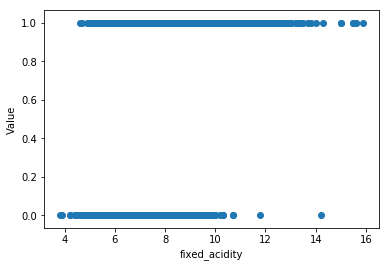

volatile_acidity


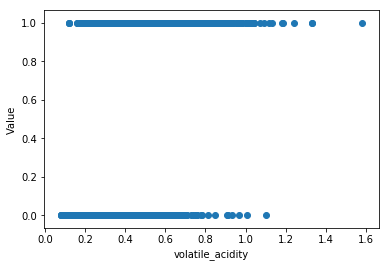

citric_acid


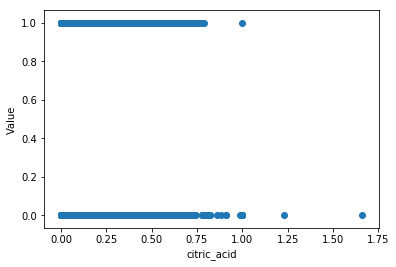

residual_sugar


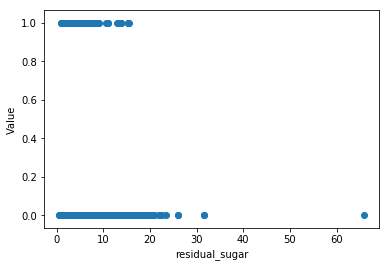

chlorides


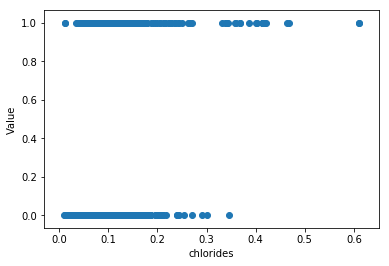

free_sulfur_dioxide


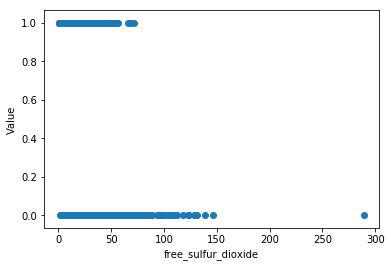

total_sulfur_dioxide


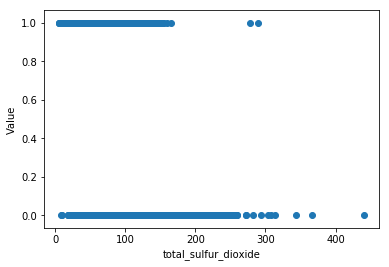

density


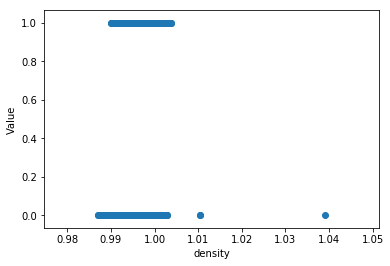

pH


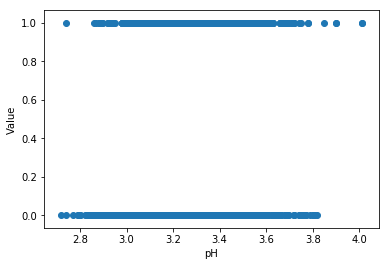

sulphates


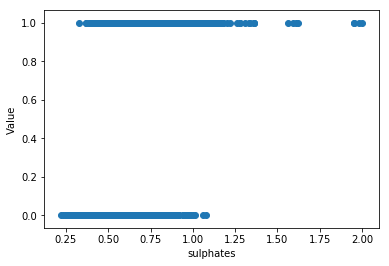

alcohol


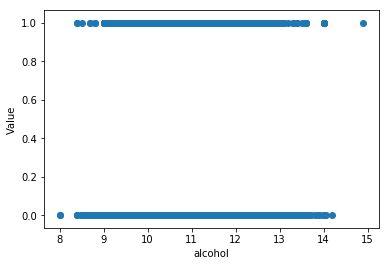

predictor


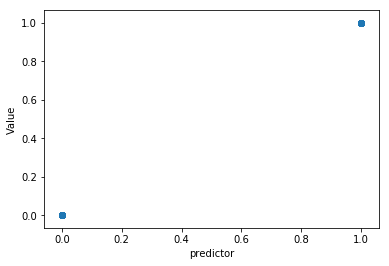

free_percentage


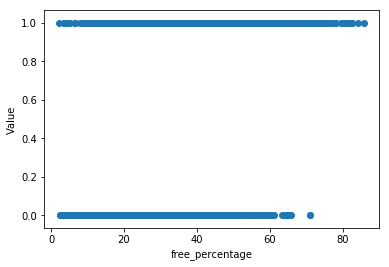

In [17]:
for column in list(wine.columns):
    print(column)
    plt.scatter(wine[column], wine["predictor"])
    plt.xlabel(f"{column}")
    plt.ylabel("Value")
    plt.show()

**Observations**:
- No total distinctions between features
- Some tend to have higher values dependent on the wine e.g. red higher chlorides and white higher residual sugar

**Plot particular features against each other into categories:**
- Free Sulphur Dioxide vs Total Sulphur Dioxide

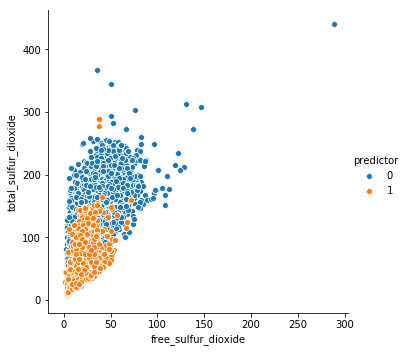

In [21]:
sns.pairplot(x_vars=["free_sulfur_dioxide"], y_vars=["total_sulfur_dioxide"], data=wine, hue="predictor", size=5);

**Observations:**
- Red tends to have lower free and total sulphur dioxide than white.
- Percentage of free sulphur therefore lower in white
- Doesn't completely separate red and white

- Residual Sugar and Citric Acid:

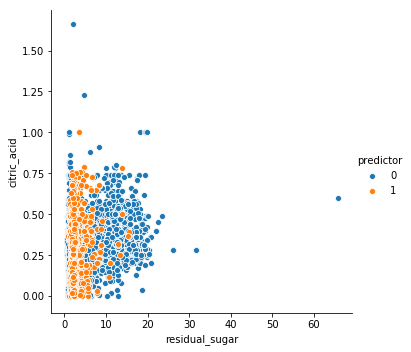

In [22]:
sns.pairplot(x_vars=["residual_sugar"], y_vars=["citric_acid"], data=wine, hue="predictor", size=5);

**Observations**: 
- Red tends to have lower residual sugars than white. 
- Citric acid tends to be around same value for both, some higher values in the whites

- Fixed acidity vs Volatile acidity

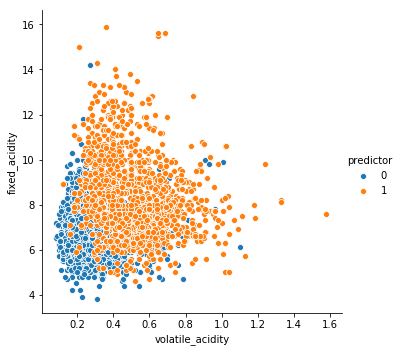

In [23]:
sns.pairplot(x_vars=["volatile_acidity"], y_vars=["fixed_acidity"], data=wine, hue="predictor", size=5);

**Observations**:
- White tends to have lower fixed and volatile acidity
- No clear divide - more clusters

**Summary:**  
White: Higher Residual Sugar, Lower total & free sulphur dioxide, Lower fixed & volatile acidity

---

# Split data

- Split into 80% Training and 20% Test

In [24]:
X = wine.drop('predictor', axis=1)
y = wine['predictor']
X_train, X_hold_out, y_train, y_hold_out = train_test_split(X, y, test_size=.20, random_state=14)

- Check stratified sampling - correct proportion of red and white in training sample

In [25]:
print(f" White Wine Samples (Train): {((y_train.value_counts()[0]/y_train.count())*100).round(2)}%")
print(f" Red Wine Samples (Train): {((y_train.value_counts()[1]/y_train.count())*100).round(2)}%")

 White Wine Samples (Train): 75.56%
 Red Wine Samples (Train): 24.44%


In [26]:
print(f" White Wine Samples (Hold out): {((y_hold_out.value_counts()[0]/y_hold_out.count())*100).round(2)}%")
print(f" Red Wine Samples (Hold out): {((y_hold_out.value_counts()[1]/y_hold_out.count())*100).round(2)}%")

 White Wine Samples (Hold out): 74.69%
 Red Wine Samples (Hold out): 25.31%


- Further split training data into 80% Train and 20% validation

In [27]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=.20, random_state=14)

**Total Splits**:  
X_train / y_train = TRAINING [4157 values (64%) ]  
X_val / y_val = VALIDATION [1040 values (16%) ]    
X_hold_out / y_hold_out = TESTING FINAL MODEL [1300 values (20%) ]

---

# Modelling

- Before modelling - want to initialise 3 empty lists to fill throughout.
- **model_name:** recording the model 
- **incorrect_predictions:** number of incorrect predictions for each model. 
- **list_of_incorrects:** lists of incorrect predictions to assess whether there are consistently incorrect predictions
- Then later assess the best models

In [28]:
model_name = []
incorrect_predictions = []
list_of_incorrects = []

---

## Baseline Model

- Predict everything is class 0 - 'White'

ROC AUC score =  0.5


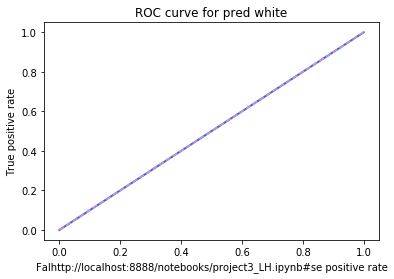

In [29]:
dc = DummyClassifier(strategy='most_frequent').fit(X_train, y_train)
dc_pred = dc.predict(X_val)
roc_auc(dc, "pred white", y_val, X_val)

<Figure size 720x504 with 0 Axes>

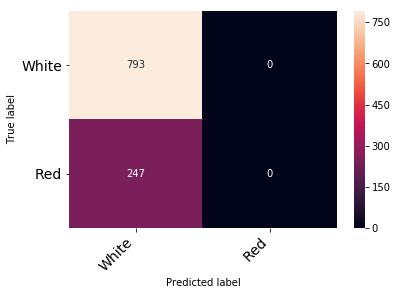

<Figure size 720x504 with 0 Axes>

In [30]:
cm = confusion_matrix(y_val, dc_pred)
print_confusion_matrix(cm, ["White", "Red"])

In [31]:
print(f"Baseline Accuracy: {accuracy_score(y_val, dc_pred).round(3)}")

Baseline Accuracy: 0.762


- Baseline Accuracy, based on data split

## Logistic Regression - All features

In [32]:
# Log Reg on train and validation data
lr = LogisticRegression(random_state=14).fit(X_train, y_train)
lr_predprob = lr.predict_proba(X_val)
lr_pred = lr.predict(X_val)

# Log Reg with Cross Validation
lr_cv = LogisticRegressionCV(random_state=14).fit(X_train, y_train)
lr_cv_predprob = lr_cv.predict_proba(X_val)
lr_cv_pred= lr_cv.predict(X_val)

In [33]:
# Check Error Metrics, ROC and Confusion Matrix
log_reg_errors(y_val, lr_pred, X_train, y_train)

'Accuracy: 0.982 CV:0.988\n    Precision: 0.979 CV:0.983\n    Recall: 0.943 CV:0.969\n    F1: 0.961 CV: 0.976'

ROC AUC score =  0.9930974978429679


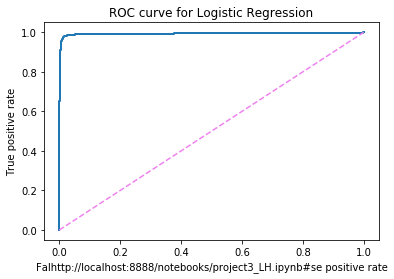

In [34]:
roc_auc(lr, "Logistic Regression", y_val, X_val)

ROC AUC score =  0.9933987165021875


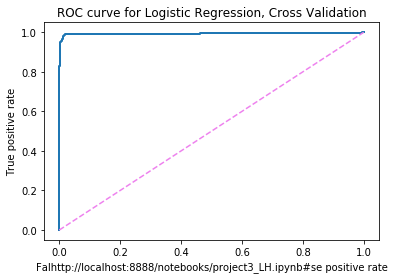

In [35]:
roc_auc(lr_cv, "Logistic Regression, Cross Validation", y_val, X_val)

<Figure size 720x504 with 0 Axes>

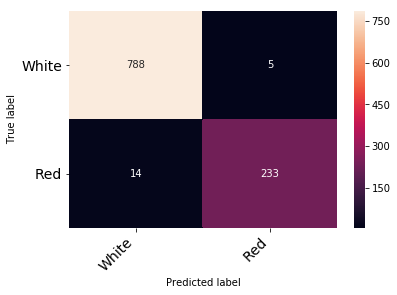

<Figure size 720x504 with 0 Axes>

In [36]:
#Confusion matrix for whole training and val in training set
lr_cm = confusion_matrix(y_val, lr_pred)
print_confusion_matrix(lr_cm, ["White", "Red"])

**Observations**:
- Error metrics, seem to be doing pretty well, use decision trees to find the best features that are used.
- Only predicting 19/1040 incorrectly

In [37]:
# Create list and dataframe of incorrectly predicted samples
logregall_incorrect = incorrect_rows(y_val, lr_pred)
logregall_incorrect_df = incorrect_df(y_val, lr_pred, lr_predprob, wine)

In [38]:
# Add model and number of predictions to list
model_name.append("Log Reg, all features")
incorrect_predictions.append(len(logregall_incorrect))
list_of_incorrects.append(logregall_incorrect)

## Decision Tree - All features

In [39]:
dtc = tree.DecisionTreeClassifier(random_state=14).fit(X_train, y_train)
y_pred_dtc_prob = dtc.predict_proba(X_val)
y_pred_dtc = dtc.predict(X_val)

In [40]:
# Decision Tree Error Metrics
print(f"Decision Tree Av Accuracy: {(cross_val_score(dtc, X_train, y_train)).mean().round(3)}")
print(f"Decision Tree Av Precision: {(cross_val_score(dtc, X_train, y_train, scoring='precision')).mean().round(3)}")
print(f"Decision Tree Av Recall: {(cross_val_score(dtc, X_train, y_train, scoring='recall')).mean().round(3)}")
print(f"Decision Tree Av F1: {(cross_val_score(dtc, X_train, y_train, scoring='f1')).mean().round(3)}")

Decision Tree Av Accuracy: 0.983
Decision Tree Av Precision: 0.968
Decision Tree Av Recall: 0.963
Decision Tree Av F1: 0.965


ROC AUC score =  0.9714276232826707


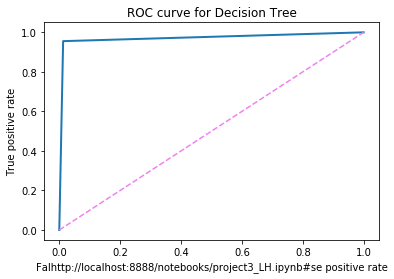

In [41]:
roc_auc(dtc, "Decision Tree", y_val, X_val)

<Figure size 720x504 with 0 Axes>

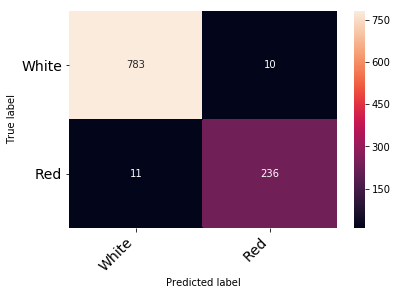

<Figure size 720x504 with 0 Axes>

In [42]:
dtc_cm = confusion_matrix(y_val, y_pred_dtc)
print_confusion_matrix(dtc_cm, ["White", "Red"])

**Observations:**
- Number of white false predictions has increased by 5, however correctly predicts 3 more red correctly 
- ROC AUC still good, however not as good as Logistic Regression

In [43]:
# Create list and dataframe of incorrectly predicted samples
dtc_incorrect = incorrect_rows(y_val, y_pred_dtc)
dtc_df = incorrect_df(y_val, y_pred_dtc, y_pred_dtc_prob, wine)

In [44]:
# Append to list
model_name.append("Decision Tree, all features")
incorrect_predictions.append(len(dtc_incorrect))
list_of_incorrects.append(dtc_incorrect)

In [45]:
# Get feature importance and create dictionary
features = list(dtc.feature_importances_.round(3))
column_names = list(wine.columns.drop('predictor'))
importance = dict(zip(column_names, features))

In [46]:
importance

{'fixed_acidity': 0.043,
 'volatile_acidity': 0.018,
 'citric_acid': 0.001,
 'residual_sugar': 0.004,
 'chlorides': 0.2,
 'free_sulfur_dioxide': 0.002,
 'total_sulfur_dioxide': 0.68,
 'density': 0.014,
 'pH': 0.003,
 'sulphates': 0.024,
 'alcohol': 0.004,
 'free_percentage': 0.005}

**Observations:**
- Two most important features are total_sulphur_dioxide and chlorides
- Least important features: citric_acid and pH

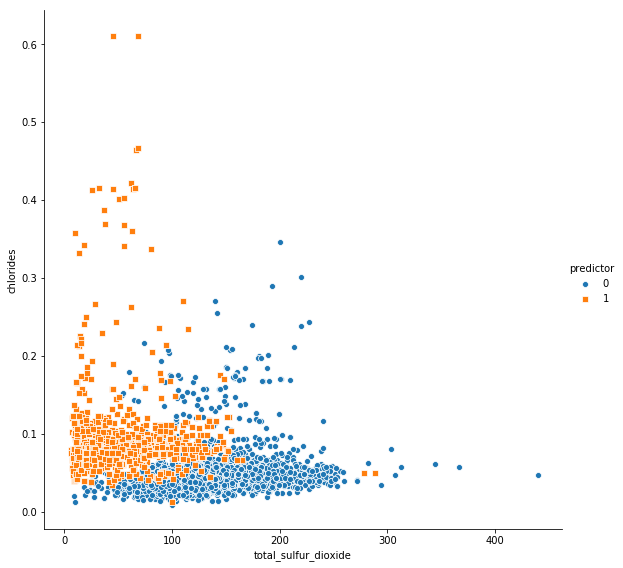

In [47]:
# plot against each other
sns.pairplot(x_vars=["total_sulfur_dioxide"], y_vars=["chlorides"], data=wine, hue="predictor", markers=["o", "s"], size=8);

**Observations:**
- Red (1) tend to have less sulphur dioxide and higher chlorides 
- White (0) Higher range of total sulphur dioxides and lower chlorides
- Seems to be a fair distinction between red and white in just these features

## Logistic Regression with just 2 features

In [48]:
# Re-define data & split - to avoid overriding of other variables
X_2 = wine[['total_sulfur_dioxide', 'chlorides']]
y_2 = wine['predictor']

X_train_2, X_hold_out_2, y_train_2, y_hold_out_2 = train_test_split(X_2, y_2, test_size=.20, random_state=14)
X_train_2, X_val_2, y_train_2, y_val_2 = train_test_split(X_train_2, y_train_2, test_size=.20, random_state=14)


In [49]:
# Logistic Regression and Cross Val Scores
lr2 = LogisticRegression(random_state=14).fit(X_train_2, y_train_2)
lr_predprob2 = lr2.predict_proba(X_val_2)
lr_pred2 = lr2.predict(X_val_2)

lr_cv_2 = LogisticRegressionCV(random_state=14).fit(X_train_2, y_train_2)
lr_cv_predprob_2 = lr_cv_2.predict_proba(X_val_2)
lr_cv_pred_2 = lr_cv_2.predict(X_val_2)

In [50]:
# Check Error Metrics, ROC and Confusion Matrix
log_reg_errors(y_val_2, lr_pred2, X_train_2, y_train_2)

'Accuracy: 0.932 CV:0.952\n    Precision: 0.904 CV:0.922\n    Recall: 0.798 CV:0.882\n    F1: 0.847 CV: 0.901'

ROC AUC score =  0.9742560154387326


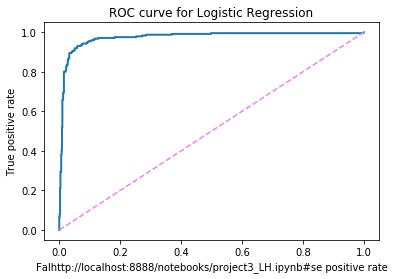

In [51]:
roc_auc(lr_cv_2, "Logistic Regression", y_val_2, X_val_2)

<Figure size 720x504 with 0 Axes>

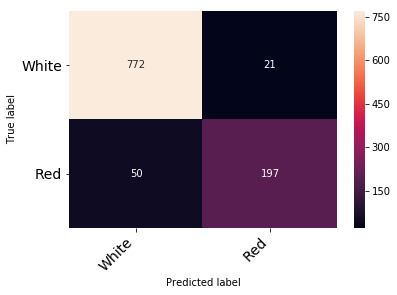

<Figure size 720x504 with 0 Axes>

In [52]:
lr2_cm = confusion_matrix(y_val_2, lr_pred2)
print_confusion_matrix(lr2_cm, ["White", "Red"])

**Observations:**
- Error metrics are lower
- Incorrectly predicting more wines - suggests that the other features are also important in prediction.
- Therefore, going to try more features

In [53]:
# Create list and dataframe of incorrect predictions
logreg_just2 = incorrect_rows(y_val_2, lr_pred2)
logreg_just2_df = incorrect_df(y_val_2, lr_pred2, lr_predprob2, wine)


In [54]:
# Add to list
model_name.append("Log Reg, Just 2 features")
incorrect_predictions.append(len(logreg_just2))
list_of_incorrects.append(logreg_just2)

## Logistic Regression with more features (>1%)

- Going to try with features that have greater than 1% importance from original decision trees

In [55]:
# Assess importance and return features with 1%+ importance
most_important = [k for k,v in importance.items() if v >= 0.01]
print(f"Most important features:\n{most_important}")

Most important features:
['fixed_acidity', 'volatile_acidity', 'chlorides', 'total_sulfur_dioxide', 'density', 'sulphates']


In [56]:
# Re-define data 
X_3 = wine[most_important]
y_3 = wine['predictor']

X_train_3, X_hold_out_3, y_train_3, y_hold_out_3 = train_test_split(X_3, y_3, test_size=.20, random_state=14)
X_train_3, X_val_3, y_train_3, y_val_3 = train_test_split(X_train_3, y_train_3, test_size=.20, random_state=14)

In [57]:
# Logistic Regression and Cross Validation
lr3 = LogisticRegression(random_state=14).fit(X_train_3, y_train_3)
lr_predprob3 = lr3.predict_proba(X_val_3)
lr_pred3 = lr3.predict(X_val_3)

lr_cv_3 = LogisticRegressionCV(random_state=14).fit(X_train_3, y_train_3)
lr_cv_predprob_3 = lr_cv_3.predict_proba(X_val_3)
lr_cv_pred_3 = lr_cv_3.predict(X_val_3)

In [58]:
# Check Error Metrics, ROC and Confusion Matrix
log_reg_errors(y_val_3, lr_pred3, X_train_3, y_train_3)

'Accuracy: 0.976 CV:0.98\n    Precision: 0.962 CV:0.96\n    Recall: 0.935 CV:0.96\n    F1: 0.949 CV: 0.96'

ROC AUC score =  0.9896666683684671


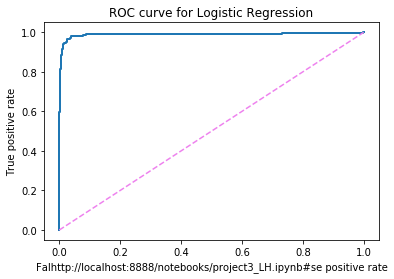

In [59]:
roc_auc(lr3, "Logistic Regression", y_val_3, X_val_3)

<Figure size 720x504 with 0 Axes>

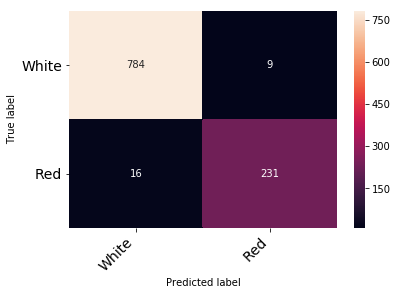

<Figure size 720x504 with 0 Axes>

In [60]:
#Confusion matrix for whole training and val in training set
lr_cm_3 = confusion_matrix(y_val_3, lr_pred3)
print_confusion_matrix(lr_cm_3, ["White", "Red"])

- **Observations**:
- Still not predicting as many as using all of the features
- Try including more features but not all

In [61]:
# Create list and dataframe of incorrectly predicted
logreg_mostimp = incorrect_rows(y_val_3, lr_pred3)
logreg_mostimp_df = incorrect_df(y_val_3, lr_pred3, lr_predprob3, wine)


In [62]:
# Add to list
model_name.append("Log Reg, 6 most important features")
incorrect_predictions.append(len(logreg_mostimp))
list_of_incorrects.append(logreg_mostimp)

## Logistic Regression with more features (>0.1%)

- Include some more features - those with higher than 0.1% importance

In [63]:
second_most_important = [k for k,v in importance.items() if v > 0.001]
print(f"Second Most important features:\n{second_most_important}")

Second Most important features:
['fixed_acidity', 'volatile_acidity', 'residual_sugar', 'chlorides', 'free_sulfur_dioxide', 'total_sulfur_dioxide', 'density', 'pH', 'sulphates', 'alcohol', 'free_percentage']


In [64]:
# Re-define data 
X_4 = wine[second_most_important]
y_4 = wine['predictor']

X_train_4, X_hold_out_4, y_train_4, y_hold_out_4 = train_test_split(X_4, y_4, test_size=.20, random_state=14)
X_train_4, X_val_4, y_train_4, y_val_4 = train_test_split(X_train_4, y_train_4, test_size=.20, random_state=14)

In [65]:
# Logistic Regression and Cross Validation
lr4 = LogisticRegression(random_state=14).fit(X_train_4, y_train_4)
lr_predprob4 = lr4.predict_proba(X_val_4)
lr_pred4 = lr4.predict(X_val_4)

lr_cv_4 = LogisticRegressionCV(random_state=14).fit(X_train_4, y_train_4)
lr_cv_predprob_4 = lr_cv_4.predict_proba(X_val_4)
lr_cv_pred_4 = lr_cv_4.predict(X_val_4)

In [66]:
# Check Error Metrics, ROC and Confusion Matrix
log_reg_errors(y_val_4, lr_pred4, X_train_4, y_train_4)

'Accuracy: 0.983 CV:0.986\n    Precision: 0.979 CV:0.979\n    Recall: 0.947 CV:0.965\n    F1: 0.963 CV: 0.972'

ROC AUC score =  0.993082181639957


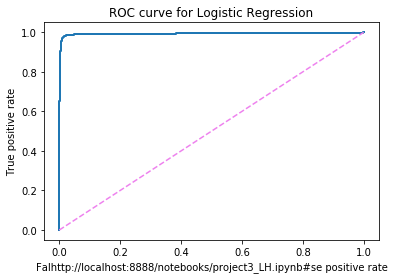

In [67]:
roc_auc(lr4, "Logistic Regression", y_val_4, X_val_4)

<Figure size 720x504 with 0 Axes>

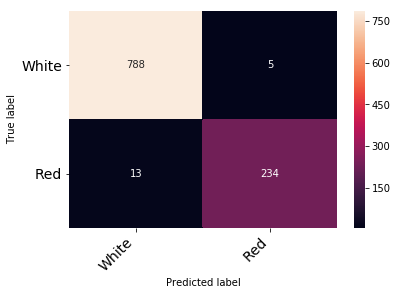

<Figure size 720x504 with 0 Axes>

In [68]:
#Confusion matrix for whole training and val in training set
lr_cm_4 = confusion_matrix(y_val_4, lr_pred4)
print_confusion_matrix(lr_cm_4, ["White", "Red"])

In [69]:
# Create list and dataframe of incorrect predictions
logreg4_incorrect = incorrect_rows(y_val_4, lr_pred4)
logreg4_incorrect_df = incorrect_df(y_val_4, lr_pred4, lr_predprob4, wine)

In [70]:
# Add to list
model_name.append("Log Reg, 10 most important features")
incorrect_predictions.append(len(logreg4_incorrect))
list_of_incorrects.append(logreg4_incorrect)

## Logistic Regression without 2 dominant features

In [71]:
# Re-define data 
X_5 = wine.drop(['total_sulfur_dioxide', 'chlorides', 'predictor'], axis=1)
y_5 = wine['predictor']

X_train_5, X_hold_out_5, y_train_5, y_hold_out_5 = train_test_split(X_5, y_5, test_size=.20, random_state=14)
X_train_5, X_val_5, y_train_5, y_val_5 = train_test_split(X_train_5, y_train_5, test_size=.20, random_state=14)

In [72]:
# Logistic Regression and Cross Validation
lr_cv_5 = LogisticRegressionCV(random_state=14).fit(X_train_5, y_train_5)
lr_cv_predprob_5 = lr_cv_5.predict_proba(X_val_5)
lr_cv_pred_5 = lr_cv_5.predict(X_val_5)

lr5 = LogisticRegression(random_state=14).fit(X_train_5, y_train_5)
lr_predprob5 = lr5.predict_proba(X_val_5)
lr_pred5 = lr5.predict(X_val_5)

In [73]:
# Check Error Metrics, ROC and Confusion Matrix
log_reg_errors(y_val_5, lr_pred5, X_train_5, y_train_5)

'Accuracy: 0.982 CV:0.986\n    Precision: 0.983 CV:0.978\n    Recall: 0.939 CV:0.965\n    F1: 0.961 CV: 0.971'

ROC AUC score =  0.992418479509473


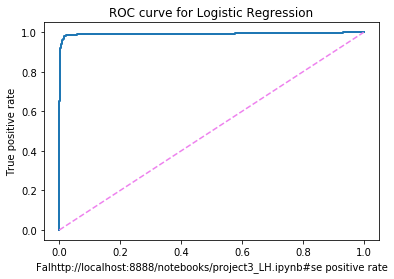

In [74]:
roc_auc(lr_cv_5, "Logistic Regression", y_val_5, X_val_5)

<Figure size 720x504 with 0 Axes>

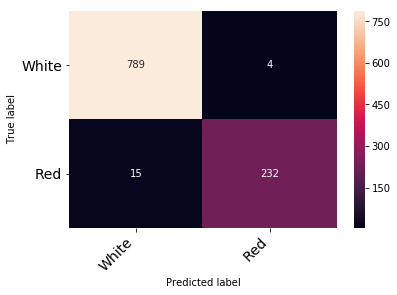

<Figure size 720x504 with 0 Axes>

In [75]:
lr5_cm = confusion_matrix(y_val_5, lr_pred5)
print_confusion_matrix(lr5_cm, ["White", "Red"])

In [76]:
# Create list and dataframe of incorrect predictions
logreg5_incorrect = incorrect_rows(y_val_5, lr_pred5)
logreg5_incorrect_df = incorrect_df(y_val_5, lr_pred5, lr_predprob5, wine)

In [77]:
# Add to list
model_name.append("Log Reg, Without 2 most important features")
incorrect_predictions.append(len(logreg5_incorrect))
list_of_incorrects.append(logreg5_incorrect)

## KNN - on all features

In [78]:
# Re define data
Xk = wine.drop('predictor', axis=1)
yk = wine['predictor']

Xk_train, Xk_hold_out, yk_train, yk_hold_out = train_test_split(Xk, yk, test_size=.20, random_state=14)
Xk_train, Xk_val, yk_train, yk_val = train_test_split(Xk_train, yk_train, test_size=.20, random_state=14)

In [79]:
# Find best K
k = list(range(1, 12))
scores = []

for i in k:
    KNN = KNeighborsClassifier(n_neighbors=i)
    KNN.fit(Xk_train, yk_train)
    y_pred_knn = KNN.predict(Xk_val)
    score = f1_score(yk_val, y_pred_knn)
    scores.append(score)

total_scores = dict(zip(k, scores))
best_k = ([k for k,v in total_scores.items() if v == max(scores)])

print(f"K with highest accuracy score = {best_k}")

K with highest accuracy score = [1]


In [80]:
KNN = KNeighborsClassifier(n_neighbors=best_k[0])
KNN.fit(Xk_train, yk_train)
y_pred_knn = KNN.predict(Xk_val)
y_predprob_knn = KNN.predict_proba(Xk_val)

In [81]:
# KNN Error Metrics
print(f"KNN Average Accuracy: {(cross_val_score(KNN, Xk_train, yk_train)).mean().round(3)}")
print(f"KNN Average Precision: {(cross_val_score(KNN, Xk_train, yk_train, scoring='precision')).mean().round(3)}")
print(f"KNN Average Recall: {(cross_val_score(KNN, Xk_train, yk_train, scoring='recall')).mean().round(3)}")
print(f"KNN Average F1: {(cross_val_score(KNN, Xk_train, yk_train, scoring='f1')).mean().round(3)}")

KNN Average Accuracy: 0.934
KNN Average Precision: 0.864
KNN Average Recall: 0.867
KNN Average F1: 0.866


ROC AUC score =  0.9155439038959314


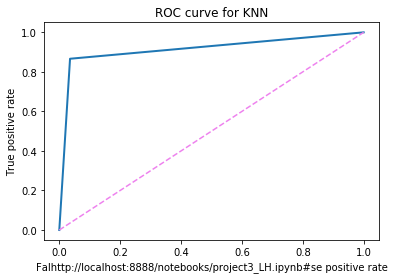

In [82]:
roc_auc(KNN, "KNN", yk_val, Xk_val)

<Figure size 720x504 with 0 Axes>

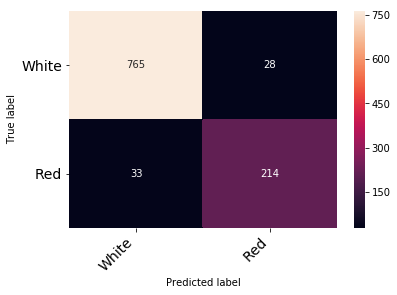

<Figure size 720x504 with 0 Axes>

In [83]:
knn_cm = confusion_matrix(yk_val, y_pred_knn)
print_confusion_matrix(knn_cm, ["White", "Red"])

**Observations:**
- Incorrectly predicting over 60 wines
- Lower recall and F1 Scores

In [84]:
# Create list and dataframe predictions
knn_incorrect = incorrect_rows(yk_val, y_pred_knn)
knn_incorrect_df = incorrect_df(yk_val, y_pred_knn, y_predprob_knn, wine)

In [85]:
# Add to list
model_name.append("KNN, All features")
incorrect_predictions.append(len(knn_incorrect))
list_of_incorrects.append(knn_incorrect)

## Random Forest Classifier - All features

In [86]:
Xrf = wine.drop('predictor', axis=1)
yrf = wine['predictor']
Xrf_train, Xrf_hold_out, yrf_train, yrf_hold_out = train_test_split(Xrf, yrf, test_size=.20, random_state=14)

In [87]:
Xrf_train, Xrf_val, yrf_train, yrf_val = train_test_split(Xrf_train, yrf_train, test_size=.20, random_state=14)

In [88]:
RFC = RandomForestClassifier(n_estimators=20, max_depth=3)
RFC.fit(Xrf_train, yrf_train)
y_pred_rfc_proba = RFC.predict_proba(Xrf_val)
y_pred_rfc = RFC.predict(Xrf_val)

ROC AUC score =  0.9956393816502509


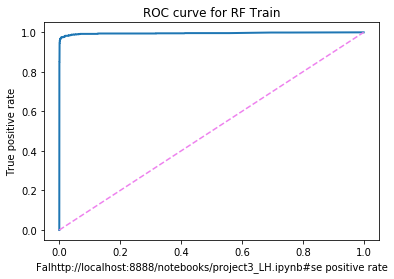

In [89]:
roc_auc(RFC, "RF Train", yrf_train, Xrf_train)

ROC AUC score =  0.9923163714893987


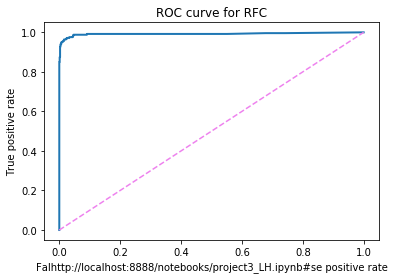

In [90]:
roc_auc(RFC, "RFC", yrf_val, Xrf_val)

<Figure size 720x504 with 0 Axes>

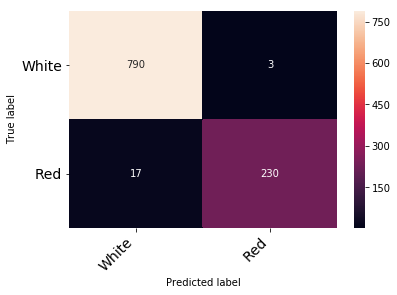

<Figure size 720x504 with 0 Axes>

In [91]:
rfc_cm = confusion_matrix(yrf_val, y_pred_rfc)
print_confusion_matrix(rfc_cm, ["White", "Red"])

In [92]:
# Create list and dataframe predictions
rfc_incorrect = incorrect_rows(yrf_val, y_pred_rfc)
rfc_incorrect_df = incorrect_df(yrf_val, y_pred_rfc, y_pred_rfc_proba, wine)

In [93]:
# Add to list
model_name.append("Random Forest, All features")
incorrect_predictions.append(len(rfc_incorrect))
list_of_incorrects.append(rfc_incorrect)

---

# Evaluate best performing models

## Assess incorrect predictions

- Create dictionary of models and number of incorrect predictions

In [94]:
incorrect_pred_dict = dict(zip(model_name, incorrect_predictions))
incorrect_pred_dict

{'Log Reg, all features': 19,
 'Decision Tree, all features': 21,
 'Log Reg, Just 2 features': 71,
 'Log Reg, 6 most important features': 25,
 'Log Reg, 10 most important features': 18,
 'Log Reg, Without 2 most important features': 19,
 'KNN, All features': 61,
 'Random Forest, All features': 20}

- Logistic Regression all features = Simplest Model
- Check if the same incorrect predictions are coming up with the rest of the models

In [95]:
no_of_same = []
for i in list_of_incorrects:
    no_of_same.append(len(set(logregall_incorrect).intersection(i)))

In [96]:
same_incorrects = dict(zip(model_name, no_of_same))
same_incorrects

{'Log Reg, all features': 19,
 'Decision Tree, all features': 6,
 'Log Reg, Just 2 features': 14,
 'Log Reg, 6 most important features': 12,
 'Log Reg, 10 most important features': 18,
 'Log Reg, Without 2 most important features': 18,
 'KNN, All features': 9,
 'Random Forest, All features': 10}

**Observations:**
- For logistic regression models the same features seem to be consistently incorrectly predicted. 
- KNN, Descision Trees & Random Forest seem to be predicting different features incorrectly - therefore ensembling models may be the answer.

- Check mean values of features in full dataset and incorrectly predicted dataframe for Logistic Regression (All features)

In [97]:
# wine dataframe means
wine.groupby('predictor').mean()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,free_percentage
predictor,,,,,,,,,,,,
0,6.854788,0.278241,0.334192,6.391415,0.045772,35.308085,138.360657,0.994027,3.188267,0.489847,10.514267,25.557613
1,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,38.231088


In [98]:
# Log Reg mean
logregall_incorrect_df.groupby('predictor').mean()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,free_percentage,white_prob,red_prob
predictor,,,,,,,,,,,,,,
0,6.340000,0.597000,0.194000,1.44,0.038600,16.600000,69.200000,0.992364,3.262000,0.438,10.520000,32.066,0.241360,0.758640
1,6.735714,0.454286,0.270714,2.90,0.069357,32.892857,113.214286,0.994761,3.358571,0.615,11.135714,30.605,0.692693,0.307307


**Observations:**
- Full dataset: Mean Total Sulphur Dioxide for White (0) is much higher than those in incorrect predictions. Opposite for Red (1), therefore may be big predictor for incorrect samples. 
- Lower residual sugar mean in incorrect predictions.
- Free sulphur dioxide means approximately reversed for incorrect predictions.
- Little differences in alcohol, sulphates, pH, chlorides

# Ensembling

## Voting Classifier on Logistic Regression and Decision Trees

In [99]:
# Redefine Data
X_vote = wine.drop('predictor', axis=1)
y_vote = wine['predictor']
X_train_vote, X_hold_out_vote, y_train_vote, y_hold_out_vote = train_test_split(X_vote, y_vote, test_size=.20, random_state=14)
X_train_vote, X_val_vote, y_train_vote, y_val_vote = train_test_split(X_train_vote, y_train_vote, test_size=.20, random_state=14)

In [100]:
clf1 = LogisticRegression(random_state=14)
clf2 = RandomForestClassifier(n_estimators=10, random_state=14)

### Hard Voting

In [101]:
# Hard voting - uses predicted class labels for majority rule voting
eclf1 = VotingClassifier(estimators=[('lr', clf1), ('dt', clf2)], voting='hard')
eclf1 = eclf1.fit(X_train_vote, y_train_vote)
eclf_pred = eclf1.predict(X_val)

<Figure size 720x504 with 0 Axes>

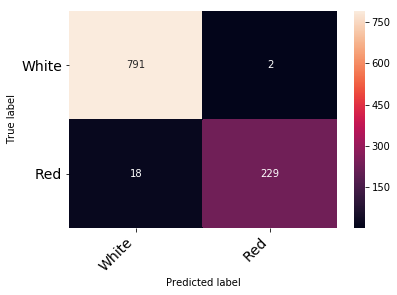

<Figure size 720x504 with 0 Axes>

In [102]:
votehard_cm = confusion_matrix(y_val_vote, eclf_pred)
print_confusion_matrix(votehard_cm, ["White", "Red"])

### Soft Voting

In [103]:
# Soft voting - predicts the class label based on the argmax of the sums of the predicted probabilities
eclf2 = VotingClassifier(estimators=[('lr', clf1), ('dt', clf2)], voting='soft')
eclf2 = eclf2.fit(X_train_vote, y_train_vote)
eclf2_pred = eclf2.predict(X_val)
eclf2_pred_proba = eclf2.predict_proba(X_val)

ROC AUC score =  0.997998682806541


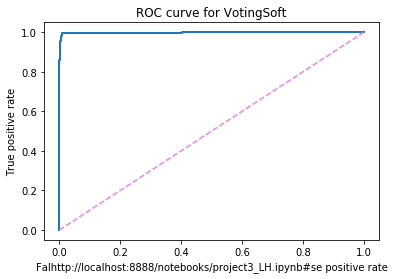

In [104]:
roc_auc(eclf2, "VotingSoft", y_val_vote, X_val_vote)

<Figure size 720x504 with 0 Axes>

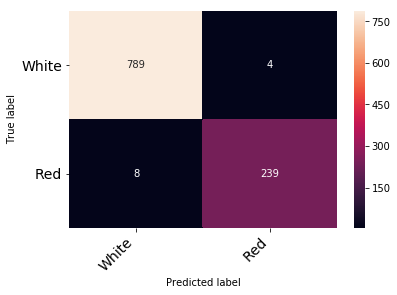

<Figure size 720x504 with 0 Axes>

In [105]:
votesoft_cm = confusion_matrix(y_val_vote, eclf2_pred)
print_confusion_matrix(votesoft_cm, ["White", "Red"])

### Weighted Voting

In [106]:
eclf3 = VotingClassifier(estimators=[('lr', clf1), ('rf', clf2)],voting='soft', weights=[5,1], flatten_transform=True)
eclf3 = eclf3.fit(X_train_vote, y_train_vote)
eclf3_pred = eclf2.predict(X_val)

ROC AUC score =  0.99728392666602


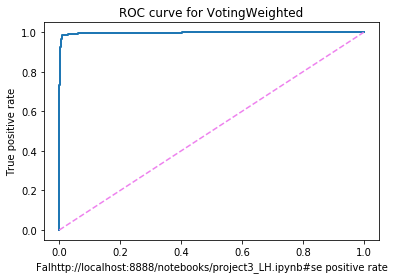

In [107]:
roc_auc(eclf3, "VotingWeighted", y_val_vote, X_val_vote)

<Figure size 720x504 with 0 Axes>

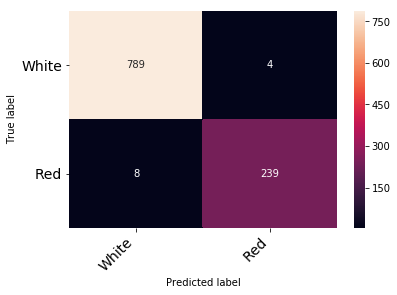

<Figure size 720x504 with 0 Axes>

In [108]:
voteweight_cm = confusion_matrix(y_val_vote, eclf3_pred)
print_confusion_matrix(voteweight_cm, ["White", "Red"])

---

# Run Model on Test Data

## Most effective model: Soft Voting Logistic Regression & Random Forest

In [109]:
vote_final_prediction = eclf2.predict(X_hold_out)
vote_final_prediction_proba = eclf2.predict_proba(X_hold_out)

In [110]:
print(f"Accuracy: {(accuracy_score(y_hold_out, vote_final_prediction)).round(3)}")
print(f"Precision: {(precision_score(y_hold_out, vote_final_prediction)).round(3)}")
print(f"F1: {(f1_score(y_hold_out, vote_final_prediction)).round(3)}")
print(f"Recall: {(recall_score(y_hold_out, vote_final_prediction)).round(3)}")

Accuracy: 0.99
Precision: 0.994
F1: 0.98
Recall: 0.967


ROC AUC score =  0.9987917072300357


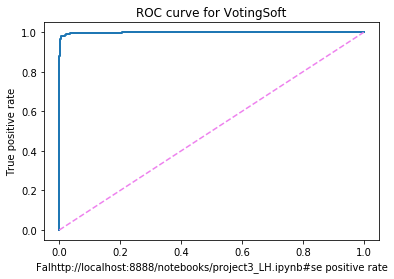

In [111]:
roc_auc(eclf2, "VotingSoft", y_hold_out, X_hold_out)

<Figure size 720x504 with 0 Axes>

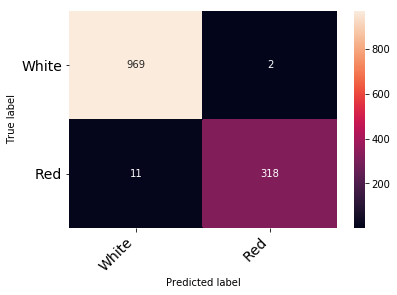

<Figure size 720x504 with 0 Axes>

In [112]:
votesoftfinal_cm = confusion_matrix(y_hold_out, vote_final_prediction)
print_confusion_matrix(votesoftfinal_cm, ["White", "Red"])

## Simplest model: Logistic Regression

In [113]:
logreg_prediction = lr.predict(X_hold_out)

In [114]:
print(f"Accuracy: {(accuracy_score(y_hold_out, logreg_prediction)).round(3)}")
print(f"Precision: {(precision_score(y_hold_out, logreg_prediction)).round(3)}")
print(f"F1: {(f1_score(y_hold_out, logreg_prediction)).round(3)}")
print(f"Recall: {(recall_score(y_hold_out, logreg_prediction)).round(3)}")

Accuracy: 0.982
Precision: 0.981
F1: 0.964
Recall: 0.948


ROC AUC score =  0.9943999073433524


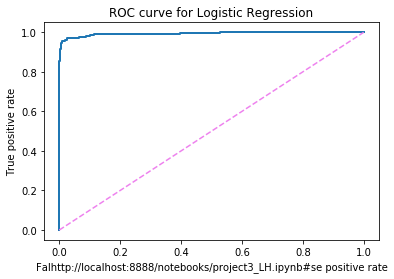

In [115]:
roc_auc(lr, "Logistic Regression", y_hold_out, X_hold_out)

<Figure size 720x504 with 0 Axes>

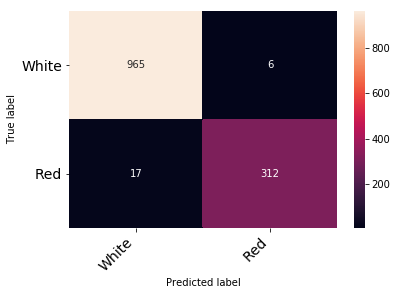

<Figure size 720x504 with 0 Axes>

In [116]:
lrfinal_cm = confusion_matrix(y_hold_out, logreg_prediction)
print_confusion_matrix(lrfinal_cm, ["White", "Red"])

---

# Tableau Prep

- Create dataframe of test data with details of model prediction

In [117]:
# Change Predictor column back to Red and White for visuals
# Create predictor column (Y) and drop text column of wine colors: 
def wine_type(number):
    '''Changes predictor value to typ again
    White = 0
    Red = 1'''
    
    if number == 0:
        return "White"
    if number == 1:
        return "Red"

wine["colour"] = wine["predictor"].apply(wine_type)
wine.drop("predictor", axis=1, inplace=True)

In [118]:
# Make test data frame
test_data = pd.concat([X_hold_out, pd.DataFrame(y_hold_out)], axis=1, sort=False)
test_data["colour"] = test_data["predictor"].apply(wine_type)
test_data.drop("predictor", axis=1, inplace=True)

# Make dataframe of incorrect predictions 
votes_incorrect = incorrect_df(y_hold_out, vote_final_prediction, vote_final_prediction_proba, wine)

# Add incorrect column on to predicted dataframe
votes_incorrect["model_prediction"] = "incorrect"

# Add to test dataframe
full_data = pd.concat([test_data, votes_incorrect], axis=1, sort=False)

# Change NaNs in prediction column to Correct
full_data.model_prediction = full_data.model_prediction.fillna('correct')

# Drop rest of the columns 
full_data.dropna(axis=1, inplace=True)

# Add sample number column
full_data["sample_number"] = range(1, len(full_data)+1)

#save dataframe as csv
full_data.to_csv('full_data.csv', index=False)

In [119]:
full_data.head()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,free_percentage,colour,model_prediction,sample_number
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,32.35,Red,correct,1
9,7.5,0.50,0.36,6.1,0.071,17.0,102.0,0.9978,3.35,0.80,10.5,16.67,Red,correct,2
13,7.8,0.61,0.29,1.6,0.114,9.0,29.0,0.9974,3.26,1.56,9.1,31.03,Red,correct,3
14,8.9,0.62,0.18,3.8,0.176,52.0,145.0,0.9986,3.16,0.88,9.2,35.86,Red,correct,4
20,8.9,0.22,0.48,1.8,0.077,29.0,60.0,0.9968,3.39,0.53,9.4,48.33,Red,correct,5


---